In [1]:
# automatically update imports
%load_ext autoreload
%autoreload 2

# For graphs
%matplotlib inline

# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [56]:
import numpy as np

city_refs = ['dublin_pleasanton', 'girona', 'sant_feilu', 'sierra_vista']
bboxes = { city_ref : bbox for city_ref, bbox in zip(city_refs, [[37.6248, -121.9603, 37.7296, -121.8202], [41.9262, 2.7692, 42.0237, 2.8489], [41.3700, 2.0203, 41.3973, 2.0774], [31.5109, -110.3800, 31.5816, -110.2052]]) }
steps = np.arange(0.005, 0.001, -0.0005)

In [3]:
import osm_loader

poiss = { city_ref : osm_loader.pois_from_bbox(bboxes[city_ref]) for city_ref in city_refs }

In [4]:
import kde

activity_step_kdes = { city_ref : {step: kde.get_grid_category_kde(poiss[city_ref], bboxes[city_ref], step) for step in steps} for city_ref in city_refs }

In [66]:
# areal decomposition sensitivity
import pandas as pd

import spatial_measures
from utils import grid_from_bbox

measure_methods = { 'geary' : spatial_measures.adjusted_geary, 'moran' : spatial_measures.moran_index }
measure_pre_methods = { 'count' : spatial_measures.grid_cell_pois_count, 'kde' : spatial_measures.grid_cell_kde_average }
measure_series = {}

for city_ref in city_refs:
    print(city_ref)
    activity_step_kde = activity_step_kdes[city_ref]
    bbox = bboxes[city_ref]
    pois = poiss[city_ref]
    city_measures = {}
    for measure_key, measure_method in measure_methods.items():
        print('\t' + measure_key)
        measure_ser = {}
        for pre_key, pre_method in measure_pre_methods.items():
            print('\t\t' + pre_key)
            pre_ser = []
            for step in steps:
                xx, yy = grid_from_bbox(bbox, step)
                if pre_key == 'count':
                    ff = pre_method(pois, xx, yy)
                else:
                    ff = pre_method(activity_step_kde[step].values)
                pre_ser.append(measure_method(ff, xx, yy))
            measure_ser[pre_key] = pd.Series(pre_ser, index=steps)
        city_measures[measure_key] = measure_ser
    measure_series[city_ref] = city_measures

dublin_pleasanton
	moran
		count


		kde


	geary
		count


		kde


girona
	moran
		count


		kde


	geary
		count


		kde


sant_feilu
	moran
		count


		kde
	geary
		count


		kde
sierra_vista
	moran
		count


		kde


	geary
		count


		kde


In [67]:
import pickle
with open('measure_series.p', 'w') as f:
    pickle.dump(measure_series, f)

In [74]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

n_cities = len(city_refs)
n_measures = len(measure_methods)

pre_colors = cm.jet_r(np.linspace(0,1,len(measure_pre_methods)))

%matplotlib qt
fig, axes = plt.subplots(n_measures, n_cities, figsize=(4 * n_cities, 4 * n_measures))
[ax.set_title(city_ref) for city_ref, ax in zip(city_refs, axes[0])]
[axs[0].set_ylabel(measure_key, rotation=90) for measure_key, axs in zip(measure_methods.keys(), axes)]
for measure_key, axs in zip(measure_methods.keys(), axes):
    for city_ref, ax in zip(city_refs, axs):
        city_sample_n = [activity_step_kdes[city_ref][step].size for step in steps]
        city_measure = measure_series[city_ref][measure_key]
        for i, pre_key in enumerate(measure_pre_methods.keys()):
            ax.plot(city_sample_n, city_measure[pre_key], color=pre_colors[i], label=pre_key)
            ax.set_xlabel('n_samples')

# TODO: add legend
# fig.legend(ax.legend())
# fig.legend(ax.get_legend())                
plt.show()

In [44]:
var_count = []
var_kde = []
for city_ref in city_refs:
    city_measures = measure_series[city_ref]
    for measure_key in measure_methods.keys():
        city_measure = city_measures[measure_key]
        var_count.append(city_measure['count'].std())
        var_kde.append(city_measure['kde'].std())

In [47]:
for var_c, var_k in zip(var_count, var_kde):
    print(var_c, var_k)

(0.0038163100306629512, 0.007889412375993091)
(0.0074527857910535091, 0.0078554827274432849)
(0.0052087750913553865, 0.0025161993363897817)
(0.0037812931885931799, 0.0027445707893173888)
(0.0056787827710771928, 0.0243501755024794)
(0.035021009477606481, 0.017649629791423389)
(0.0075803153709257222, 0.0049404041596745269)
(0.012179990510114, 0.0035865247549372883)


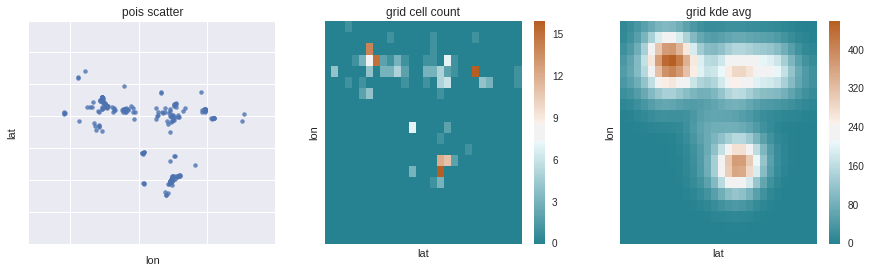

In [304]:
import seaborn as sns

shape = xx.shape[0]-1, xx.shape[1]-1
count_mat = spatial_measures.grid_cell_pois_count(pois, xx, yy).reshape(shape)
kde_mat = spatial_measures.grid_cell_kde_average(f).reshape(shape)

%matplotlib inline
hm_kwargs = {'cmap': sns.diverging_palette(210, 30, s=90, sep=20, as_cmap=True), 'xticklabels': False, 'yticklabels': False}
fig, axes = plt.subplots(1,3, figsize=(15, 4))
axes[0].set_title('pois scatter')
sns.regplot('lon', 'lat', data=pois, ax=axes[0], fit_reg=False)
axes[0].xaxis.set_ticklabels([])
axes[0].yaxis.set_ticklabels([])

for ax, title, mat in zip(axes[1:], ['grid cell count', 'grid kde avg'], map(np.flipud, [count_mat, kde_mat])):
    ax.set_title(title)
    sns.heatmap(mat, ax=ax, **hm_kwargs)
    ax.set_xlabel('lat')
    ax.set_ylabel('lon')


plt.show()